In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
NUM_CLASSES = 3 
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 50
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

In [3]:
class CamVidDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.png', '_L.png'))
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            # mask = torch.from_numpy(np.array(mask)).long()
        
        return image, mask

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [5]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder1 = DoubleConv(3, 64)
        self.encoder2 = DoubleConv(64, 128)
        self.encoder3 = DoubleConv(128, 256)
        self.encoder4 = DoubleConv(256, 512)
        
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.decoder3 = DoubleConv(256 + 512, 256)
        self.decoder2 = DoubleConv(128 + 256, 128)
        self.decoder1 = DoubleConv(128 + 64, 64)
        
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        # Decoder
        dec3 = self.decoder3(torch.cat([self.upsample(enc4), enc3], dim=1))
        dec2 = self.decoder2(torch.cat([self.upsample(dec3), enc2], dim=1))
        dec1 = self.decoder1(torch.cat([self.upsample(dec2), enc1], dim=1))
        # print(dec1.shape)
        return self.final_conv(dec1)


In [6]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        # print(outputs.shape, masks.shape)
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

In [7]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
    save_image(outputs[0], 'img.jpg')
    return total_loss / len(val_loader)

In [10]:
def main():
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Data transforms
    transform = transforms.Compose([
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    mask_transform = transforms.Compose([
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = CamVidDataset(
        image_dir='camvid_data/train',
        mask_dir='camvid_data/train_labels',
        transform=transform
    )
    val_dataset = CamVidDataset(
        image_dir='camvid_data/val',
        mask_dir='camvid_data/val_labels',
        transform=transform
    )
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    # Initialize model, criterion, and optimizer
    model = UNet(NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        val_loss = validate_model(model, val_loader, criterion, device)
        
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

In [9]:
def predict(model, image_path, device):
    transform = transforms.Compose([
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        prediction = output.argmax(1).squeeze().cpu().numpy()
    
    return prediction

if __name__ == '__main__':
    main()

100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Epoch 1/50
Train Loss: -6.9049, Val Loss: -9.5609


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Epoch 2/50
Train Loss: -10.2919, Val Loss: -10.4877


100%|██████████| 25/25 [00:08<00:00,  3.08it/s]


Epoch 3/50
Train Loss: -13.2637, Val Loss: -13.2264


100%|██████████| 25/25 [00:08<00:00,  3.08it/s]


Epoch 4/50
Train Loss: -16.4682, Val Loss: -16.8458


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


Epoch 5/50
Train Loss: -19.8458, Val Loss: -19.2247


100%|██████████| 25/25 [00:08<00:00,  3.01it/s]


Epoch 6/50
Train Loss: -23.2819, Val Loss: -23.1338


100%|██████████| 25/25 [00:07<00:00,  3.18it/s]


Epoch 7/50
Train Loss: -27.0483, Val Loss: -28.7476


100%|██████████| 25/25 [00:07<00:00,  3.20it/s]


Epoch 8/50
Train Loss: -31.0093, Val Loss: -34.5903


100%|██████████| 25/25 [00:07<00:00,  3.19it/s]


Epoch 9/50
Train Loss: -35.0590, Val Loss: -35.9486


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Epoch 10/50
Train Loss: -39.2990, Val Loss: -44.8094


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Epoch 11/50
Train Loss: -43.8278, Val Loss: -43.8794


100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Epoch 12/50
Train Loss: -48.5357, Val Loss: -48.4730


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Epoch 13/50
Train Loss: -53.2034, Val Loss: -52.2704


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Epoch 14/50
Train Loss: -58.1807, Val Loss: -59.3069


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Epoch 15/50
Train Loss: -63.5933, Val Loss: -59.4673


100%|██████████| 25/25 [00:04<00:00,  6.01it/s]


Epoch 16/50
Train Loss: -69.3048, Val Loss: -61.3502


100%|██████████| 25/25 [00:04<00:00,  6.05it/s]


Epoch 17/50
Train Loss: -74.7904, Val Loss: -75.8060


100%|██████████| 25/25 [00:04<00:00,  6.12it/s]


Epoch 18/50
Train Loss: -80.5707, Val Loss: -78.7583


100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


Epoch 19/50
Train Loss: -86.5361, Val Loss: -84.9305


100%|██████████| 25/25 [00:04<00:00,  6.21it/s]


Epoch 20/50
Train Loss: -92.5129, Val Loss: -83.1906


100%|██████████| 25/25 [00:04<00:00,  5.99it/s]


Epoch 21/50
Train Loss: -98.6952, Val Loss: -94.1472


100%|██████████| 25/25 [00:04<00:00,  5.82it/s]


Epoch 22/50
Train Loss: -104.5591, Val Loss: -110.5600


100%|██████████| 25/25 [00:04<00:00,  6.10it/s]


Epoch 23/50
Train Loss: -110.9825, Val Loss: -106.6413


100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


Epoch 24/50
Train Loss: -118.0712, Val Loss: -114.4983


100%|██████████| 25/25 [00:04<00:00,  6.14it/s]


Epoch 25/50
Train Loss: -124.7810, Val Loss: -119.0270


100%|██████████| 25/25 [00:04<00:00,  6.24it/s]


Epoch 26/50
Train Loss: -131.6439, Val Loss: -126.1044


100%|██████████| 25/25 [00:04<00:00,  6.12it/s]


Epoch 27/50
Train Loss: -138.6952, Val Loss: -131.4069


100%|██████████| 25/25 [00:04<00:00,  5.26it/s]


Epoch 28/50
Train Loss: -145.8882, Val Loss: -138.4736


100%|██████████| 25/25 [00:04<00:00,  5.57it/s]


Epoch 29/50
Train Loss: -152.9064, Val Loss: -145.4807


100%|██████████| 25/25 [00:04<00:00,  5.45it/s]


Epoch 30/50
Train Loss: -158.4397, Val Loss: -152.6766


100%|██████████| 25/25 [00:04<00:00,  5.89it/s]


Epoch 31/50
Train Loss: -166.5698, Val Loss: -158.2205


100%|██████████| 25/25 [00:04<00:00,  5.57it/s]


Epoch 32/50
Train Loss: -175.6372, Val Loss: -167.9954


100%|██████████| 25/25 [00:04<00:00,  5.45it/s]


Epoch 33/50
Train Loss: -183.1698, Val Loss: -174.2768


100%|██████████| 25/25 [00:04<00:00,  5.49it/s]


Epoch 34/50
Train Loss: -191.0272, Val Loss: -183.4126


100%|██████████| 25/25 [00:04<00:00,  5.59it/s]


Epoch 35/50
Train Loss: -199.3028, Val Loss: -185.5788


100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


Epoch 36/50
Train Loss: -207.4718, Val Loss: -191.7618


100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Epoch 37/50
Train Loss: -215.4127, Val Loss: -206.2365


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Epoch 38/50
Train Loss: -224.1402, Val Loss: -217.0884


100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Epoch 39/50
Train Loss: -232.9246, Val Loss: -222.9673


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Epoch 40/50
Train Loss: -240.6674, Val Loss: -220.3914


100%|██████████| 25/25 [00:10<00:00,  2.37it/s]


Epoch 41/50
Train Loss: -248.9871, Val Loss: -248.9138


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Epoch 42/50
Train Loss: -258.3852, Val Loss: -244.4378


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Epoch 43/50
Train Loss: -267.4287, Val Loss: -253.2684


100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Epoch 44/50
Train Loss: -276.4984, Val Loss: -263.1583


100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Epoch 45/50
Train Loss: -285.7449, Val Loss: -256.5368


100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


Epoch 46/50
Train Loss: -295.3854, Val Loss: -279.9380


100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


Epoch 47/50
Train Loss: -304.7210, Val Loss: -278.2360


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


Epoch 48/50
Train Loss: -313.9459, Val Loss: -302.2529


100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Epoch 49/50
Train Loss: -323.5867, Val Loss: -312.5674


100%|██████████| 25/25 [00:03<00:00,  6.34it/s]

Epoch 50/50
Train Loss: -334.3950, Val Loss: -307.6881


In [16]:
def visualize_predictions(model, image_path, mask_path, device):
    """Visualize the model's predictions."""
    # Get the prediction
    prediction = predict(model, image_path, device)
    
    # Load the ground truth mask for comparison
    true_mask = Image.open(mask_path).convert('L')  # Load as grayscale for visualization
    
    # Plot the original image, ground truth mask, and predicted mask
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Load original image
    original_image = Image.open(image_path).convert('RGB')

    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(true_mask, cmap='gray')
    axs[1].set_title('Ground Truth Mask')
    axs[1].axis('off')

    axs[2].imshow(prediction, cmap='gray')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')

    plt.show()


In [17]:
import torch

# Define a function to load the saved model
def load_model(model, checkpoint_path, device):
    # Load the state dict from the saved checkpoint
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize the model (must match the architecture used during training)
    model = UNet(NUM_CLASSES).to(device)
    
    # Path to the saved model checkpoint
    checkpoint_path = 'best_model.pth'  # Replace with your actual path
    
    # Load the model
    model = load_model(model, checkpoint_path, device)
    
    print("Model loaded successfully!")


Model loaded successfully!


C:\Users\Jesus\AppData\Local\Temp\ipykernel_20036\3175940952.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locati

C:\Users\Jesus\AppData\Local\Temp\ipykernel_20036\415978354.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locatio

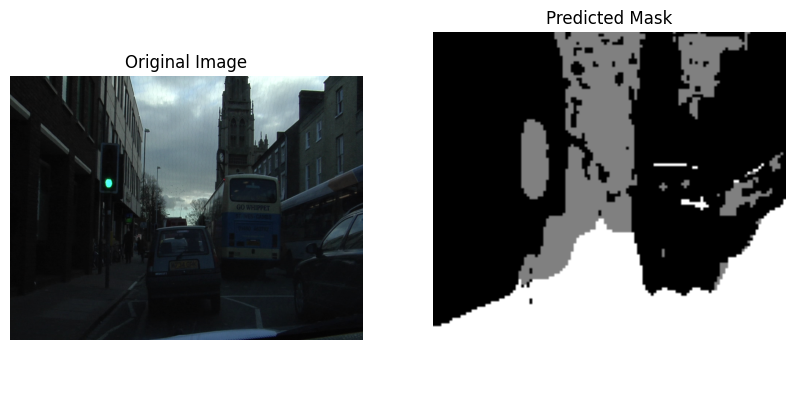

In [18]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Define a function to load the saved model
def load_model(model, checkpoint_path, device):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()  # Set the model to evaluation mode
    return model

# Define a function to preprocess and predict the mask for a given image
def predict(model, image_path, device):
    transform = transforms.Compose([
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    with torch.no_grad():
        output = model(input_tensor)
        prediction = output.argmax(1).squeeze().cpu().numpy()  # Get the predicted class for each pixel
    
    return prediction

# Define a function to visualize predictions
def visualize_predictions(model, image_path, device):
    prediction = predict(model, image_path, device)
    
    # Plot the original image and predicted mask
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Load the original image
    original_image = Image.open(image_path).convert('RGB')

    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(prediction, cmap='gray')
    axs[1].set_title('Predicted Mask')
    axs[1].axis('off')

    plt.show()

# Main code to load the model and predict the segmentation mask for an image
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize and load the pre-trained model
    model = UNet(NUM_CLASSES).to(device)
    model = load_model(model, 'best_model.pth', device)
    
    # Path to the user-provided image
    user_image_path = 'camvid_data/train/0001TP_006690.png'  
    
    # Visualize the predictions
    visualize_predictions(model, user_image_path, device)


C:\Users\Jesus\AppData\Local\Temp\ipykernel_20036\415978354.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locatio

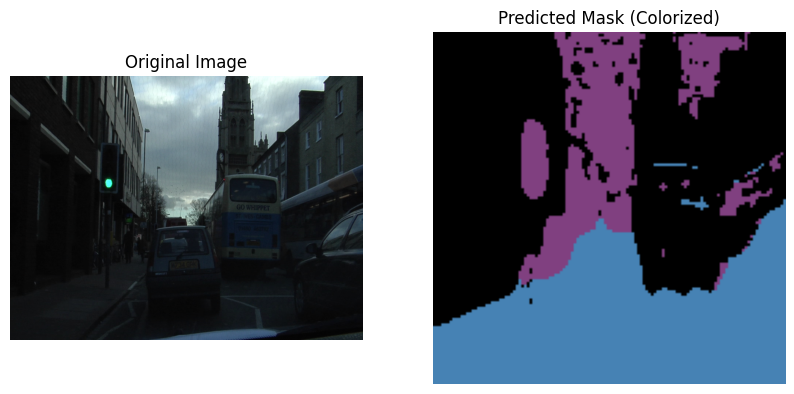

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define a color map for the segmentation mask
def create_colormap():
    # Example: For 3 classes (background, road, vehicle)
    colormap = np.zeros((NUM_CLASSES, 3), dtype=int)
    colormap[0] = [0, 0, 0]       # Background - Black
    colormap[1] = [128, 64, 128]  # Road - Purple
    colormap[2] = [70, 130, 180]  # Vehicle - Blue
    return colormap

def colorize_mask(mask):
    colormap = create_colormap()
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    
    for label in range(NUM_CLASSES):
        color_mask[mask == label] = colormap[label]
    
    return color_mask

# Define a function to visualize predictions with colorized mask
def visualize_predictions(model, image_path, device):
    prediction = predict(model, image_path, device)
    
    # Colorize the predicted mask
    color_mask = colorize_mask(prediction)
    
    # Plot the original image and predicted colorized mask
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Load the original image
    original_image = Image.open(image_path).convert('RGB')

    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(color_mask)
    axs[1].set_title('Predicted Mask (Colorized)')
    axs[1].axis('off')

    plt.show()

# Main code to load the model and predict the segmentation mask for an image
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize and load the pre-trained model
    model = UNet(NUM_CLASSES).to(device)
    model = load_model(model, 'best_model.pth', device)
    
    # Path to the user-provided image
    user_image_path = 'camvid_data/train/0001TP_006690.png'  # Replace with the path to your image
    
    # Visualize the predictions with colorized mask
    visualize_predictions(model, user_image_path, device)
